In [10]:
%matplotlib inline
import pandas as pd

In [11]:
compras_df = pd.read_csv('data/compras_df_enriched.csv')

## Probar un modelo Supervisado 

Preparación de los datos

Copia el DataFrame: Crea una copia del DataFrame original para no modificar los datos originales.

Iteración por columnas: Recorre todas las columnas del DataFrame.

Manejo de columnas de tipo objeto: Si la columna es de tipo objeto (generalmente texto), rellena los valores faltantes con la moda (el valor más frecuente) y luego convierte la columna a tipo categórico y asigna códigos numéricos a cada categoría.

Manejo de columnas numéricas: Si la columna es numérica, rellena los valores faltantes con la mediana.

In [34]:
data = compras_df.copy()
for i, column in enumerate(list([str(d) for d in data.dtypes])):
    if column == "object":
        data[data.columns[i]] = data[data.columns[i]].fillna(data[data.columns[i]].mode())
        data[data.columns[i]] = data[data.columns[i]].astype("category").cat.codes
    else:
        data[data.columns[i]] = data[data.columns[i]].fillna(data[data.columns[i]].median())

data.head(5)

,NUM BEN,BENEFICIARIO,RFC,FACTURA,CONTRATO,CONCEPTO,TIPO,# OP,FECHA,IMPORTE,SHEET
0,110152,161,167,1388,130,780,1,1019110.0,8,14911.80,2
1,110152,161,167,1389,135,845,1,1019110.0,8,2528.80,2
2,110152,161,167,1390,132,759,1,1019110.0,8,8500.02,2
3,110152,161,167,1391,131,757,1,1019110.0,8,2400.01,2
4,110152,161,167,1392,417,859,1,299001496.0,16,1537.00,2


In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [16]:
y = data.pop('IMPORTE') # Definición de la variable objeto
x = data.copy()

In [35]:
# Divide los datos en conjuntos de entrenamiento. El parámetro test_size=0.33 indica que el 33% de los datos se utilizarán para la prueba.
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [19]:
#  Crea un modelo de bosque aleatorio con 1000 árboles y una profundidad máxima de 4.
clf = RandomForestRegressor(n_estimators=1000, max_depth = 4)

In [21]:
clf.fit(X_train, Y_train)

RandomForestRegressor(max_depth=4, n_estimators=1000)

In [22]:
#Importa la métrica R2: Importa la métrica R2 para evaluar el rendimiento del modelo.
from sklearn.metrics import r2_score

In [24]:
#Calcula el R2: Calcula el coeficiente de determinación R2 para evaluar qué tan bien el modelo predice los valores reales.
r2_score(Y_test, clf.predict(X_test))

0.1626953477867621

## Probar un modelo no supervisado

In [55]:
import gensim
from nltk.corpus import stopwords
import numpy as np
np.random.seed(2021)

In [56]:
def preprocess (text):
    result = []
    for token in text.split():
        if token not in stopwords.words('spanish') and len(token)>4:
            result.append(token)
        return result

In [57]:
process_business = [preprocess(x) for x in list(compras_df['BENEFICIARIO'].unique())]

In [58]:
dictionary = gensim.corpora.Dictionary(process_business)

In [60]:
dictionary.filter_extremes(no_below=1, no_above=0.5)

In [61]:
bow_corpus = [dictionary.doc2bow(doc) for doc in process_business]

In [62]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=6, id2word=dictionary, passes=10, workers=2)

In [65]:
for idx, type_business in lda_model.print_topics(-1):
    print('Topic:{} Words:{}'.format(idx, type_business))

Topic:0 Words:0.068*"RODRIGUEZ" + 0.055*"INSTITUTO" + 0.042*"BANCO" + 0.029*"CANTU" + 0.029*"UNIVERSIDAD" + 0.029*"HERNANDEZ" + 0.029*"SERVICIO" + 0.029*"GRUPO" + 0.028*"RAMOS" + 0.015*"ESPINOSA"
Topic:1 Words:0.085*"GARCIA" + 0.044*"PEREZ" + 0.030*"LOZANO" + 0.030*"VARGAS" + 0.030*"MORENO" + 0.030*"INTEGRACION" + 0.030*"INMOBILIARIA" + 0.016*"MELCHOR" + 0.016*"LOGOMUNDO," + 0.016*"MADERA"
Topic:2 Words:0.123*"CONSTRUCTORA" + 0.056*"SEGUROS" + 0.042*"TREVIÑO" + 0.029*"GUERRERO" + 0.016*"PRAXAIR" + 0.016*"F/4086906" + 0.016*"CORONEL" + 0.016*"AYALA" + 0.016*"CERVEZAS" + 0.016*"VERGARA"
Topic:3 Words:0.068*"CONSTRUCCIONES" + 0.055*"DESARROLLOS" + 0.042*"VILLARREAL" + 0.015*"BENITES" + 0.015*"TIJERINA" + 0.015*"INDUSTRIAS" + 0.015*"HOSP.UNIVERSITARIO" + 0.015*"FIDEICOMISO" + 0.015*"VALLEJO" + 0.015*"EDIFICIOS"
Topic:4 Words:0.031*"CENTRO" + 0.031*"DESARROLLO" + 0.017*"TRACTORES" + 0.017*"FORTERRA," + 0.017*"MAYORGA" + 0.017*"FLORES" + 0.017*"PADILLA" + 0.017*"CORPUS" + 0.017*"IIRSACERO," 

In [70]:
def get_max_topic(index):
    results = lda_model[bow_corpus[index]]
    return max(lda_model[results], key=lambda x: x[1]) [0]

In [76]:
business_cluster = {x: get_max_topic(i) for i, x in enumerate(list(compras_df['BENEFICIARIO'].unique()))}

In [79]:
compras_df['CLUSTER_NAME'] = compras_df['BENEFICIARIO'].apply(lambda x: business_cluster[x])

<Axes: xlabel='CLUSTER_NAME'>

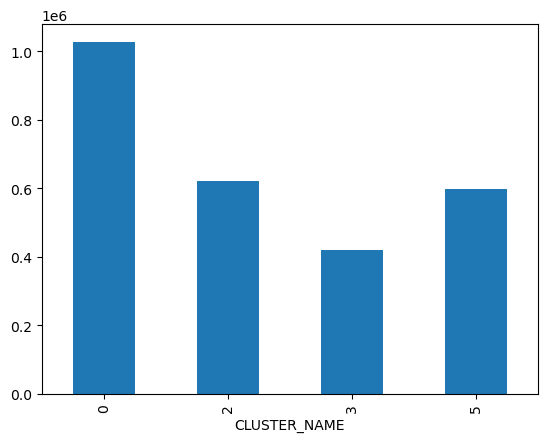

In [80]:
compras_df.groupby('CLUSTER_NAME')['IMPORTE'].mean().plot.bar()

## Probar un modelo no supervisado de anomalías en cuanto a importe

In [81]:
import numpy as np
from scipy.stats import norm

In [83]:
params = norm.fit(compras_df['IMPORTE'])

In [84]:
params

(626317.9473441559, 4665396.47441213)

In [85]:
compras_df['PROB_TOTAL'] = [norm(params[0], params[1]).cdf(x) for x in compras_df['IMPORTE']]

In [87]:
compras_df[compras_df['PROB_TOTAL']>0.95]

,NUM BEN,BENEFICIARIO,RFC,FACTURA,CONTRATO,CONCEPTO,TIPO,# OP,FECHA,IMPORTE,SHEET,CLUSTER_NAME,PROB_TOTAL
283,116684,"INDUSTRIAS SOLA BASIC, S.A. DE C.V.",ISB840628IB2,GS106845-158003-5868,SSP-189-2017,MANTENIMIENTO PREVENTIVO Y CORRECTIVO DE LOS T...,TR,604000051.0,2020-12-30,9.000000e+06,GASTOS VARIOS,2,0.963661
353,126224,"BANCO MULTIVA, SA. G.F.M.",BMI061005NY5,FS-23-2020-158004-1712,NO APLICA,FONDO SAPS 23-2020,TR,1019137.0,2020-12-11,9.071256e+06,GASTOS VARIOS,3,0.964862
354,126224,"BANCO MULTIVA, SA. G.F.M.",BMI061005NY5,FS-24-2020-158004-1751,NO APLICA,FONDO SAPS 24-2020,TR,1019152.0,2020-12-18,9.078245e+06,GASTOS VARIOS,3,0.964978
357,126671,"BANCO BANCREA,S.A. ,FIDEICOMISO NUMERO BP417",BBA130722BR7,144-153001-167,NO APLICA,APORTACIÓN MUNICIPAL AL FIDEICOMISO LA GRAN CI...,TR,1019122.0,2020-12-11,3.000000e+07,GASTOS VARIOS,3,1.000000
367,206894,MUNICIPIO DE LA CIUDAD DE MONTERREY,MCM610101PT2,2020-23-A-158004-1734,NO APLICA,"PAGO DE NÓMINA PERIODO: 23-2020, BANCO: BANCA ...",TR,11000196.0,2020-12-17,7.386437e+07,GASTOS VARIOS,2,1.000000
368,206894,MUNICIPIO DE LA CIUDAD DE MONTERREY,MCM610101PT2,2020-23-B-158004-1735,NO APLICA,"PAGO DE NÓMINA PERIODO: 23-2020, BANCO: BANCO ...",TR,231000103.0,2020-12-17,7.635249e+07,GASTOS VARIOS,2,1.000000
369,206894,MUNICIPIO DE LA CIUDAD DE MONTERREY,MCM610101PT2,2020-23-C-158004-1733,NO APLICA,"PAGO DE NÓMINA PERIODO: 23-2020, BANCO: BANCO ...",TR,240000108.0,2020-12-17,1.924614e+07,GASTOS VARIOS,2,0.999967
370,206894,MUNICIPIO DE LA CIUDAD DE MONTERREY,MCM610101PT2,2020-24-A-158004-1760,NO APLICA,"PAGO DE NÓMINA PERIODO: 24-2020, BANCO: BANCA ...",TR,11000197.0,2020-12-28,3.610189e+07,GASTOS VARIOS,2,1.000000
372,206894,MUNICIPIO DE LA CIUDAD DE MONTERREY,MCM610101PT2,2020-24-B-158004-1761,NO APLICA,"PAGO DE NÓMINA PERIODO: 24-2020, BANCO: BANCO ...",TR,231000104.0,2020-12-28,3.357936e+07,GASTOS VARIOS,2,1.000000
374,206894,MUNICIPIO DE LA CIUDAD DE MONTERREY,MCM610101PT2,2020-24-C-158004-1759,NO APLICA,"PAGO DE NÓMINA PERIODO: 24-2020, BANCO: BANCO ...",TR,240000109.0,2020-12-28,1.336286e+07,GASTOS VARIOS,2,0.996833


In [88]:
models_sheet={}
for sheet in list(compras_df['SHEET'].unique()):
    sheet_compras = compras_df[compras_df['SHEET'] == sheet]
    params = norm.fit(sheet_compras['IMPORTE'])
    models_sheet[sheet] = norm(params[0], params[1])

In [93]:
sheet_prob = []
for i, row in compras_df.iterrows():
    sheet_prob.append(models_sheet[row['SHEET']].cdf(row['IMPORTE']))
compras_df['PROB_SHEET']= sheet_prob

In [97]:
compras_df[compras_df['PROB_SHEET']>0.95]

,NUM BEN,BENEFICIARIO,RFC,FACTURA,CONTRATO,CONCEPTO,TIPO,# OP,FECHA,IMPORTE,SHEET,CLUSTER_NAME,PROB_TOTAL,PROB_SHEET
283,116684,"INDUSTRIAS SOLA BASIC, S.A. DE C.V.",ISB840628IB2,GS106845-158003-5868,SSP-189-2017,MANTENIMIENTO PREVENTIVO Y CORRECTIVO DE LOS T...,TR,604000051.0,2020-12-30,9.000000e+06,GASTOS VARIOS,2,0.963661,0.953737
353,126224,"BANCO MULTIVA, SA. G.F.M.",BMI061005NY5,FS-23-2020-158004-1712,NO APLICA,FONDO SAPS 23-2020,TR,1019137.0,2020-12-11,9.071256e+06,GASTOS VARIOS,3,0.964862,0.955151
354,126224,"BANCO MULTIVA, SA. G.F.M.",BMI061005NY5,FS-24-2020-158004-1751,NO APLICA,FONDO SAPS 24-2020,TR,1019152.0,2020-12-18,9.078245e+06,GASTOS VARIOS,3,0.964978,0.955287
357,126671,"BANCO BANCREA,S.A. ,FIDEICOMISO NUMERO BP417",BBA130722BR7,144-153001-167,NO APLICA,APORTACIÓN MUNICIPAL AL FIDEICOMISO LA GRAN CI...,TR,1019122.0,2020-12-11,3.000000e+07,GASTOS VARIOS,3,1.000000,1.000000
367,206894,MUNICIPIO DE LA CIUDAD DE MONTERREY,MCM610101PT2,2020-23-A-158004-1734,NO APLICA,"PAGO DE NÓMINA PERIODO: 23-2020, BANCO: BANCA ...",TR,11000196.0,2020-12-17,7.386437e+07,GASTOS VARIOS,2,1.000000,1.000000
368,206894,MUNICIPIO DE LA CIUDAD DE MONTERREY,MCM610101PT2,2020-23-B-158004-1735,NO APLICA,"PAGO DE NÓMINA PERIODO: 23-2020, BANCO: BANCO ...",TR,231000103.0,2020-12-17,7.635249e+07,GASTOS VARIOS,2,1.000000,1.000000
369,206894,MUNICIPIO DE LA CIUDAD DE MONTERREY,MCM610101PT2,2020-23-C-158004-1733,NO APLICA,"PAGO DE NÓMINA PERIODO: 23-2020, BANCO: BANCO ...",TR,240000108.0,2020-12-17,1.924614e+07,GASTOS VARIOS,2,0.999967,0.999929
370,206894,MUNICIPIO DE LA CIUDAD DE MONTERREY,MCM610101PT2,2020-24-A-158004-1760,NO APLICA,"PAGO DE NÓMINA PERIODO: 24-2020, BANCO: BANCA ...",TR,11000197.0,2020-12-28,3.610189e+07,GASTOS VARIOS,2,1.000000,1.000000
372,206894,MUNICIPIO DE LA CIUDAD DE MONTERREY,MCM610101PT2,2020-24-B-158004-1761,NO APLICA,"PAGO DE NÓMINA PERIODO: 24-2020, BANCO: BANCO ...",TR,231000104.0,2020-12-28,3.357936e+07,GASTOS VARIOS,2,1.000000,1.000000
374,206894,MUNICIPIO DE LA CIUDAD DE MONTERREY,MCM610101PT2,2020-24-C-158004-1759,NO APLICA,"PAGO DE NÓMINA PERIODO: 24-2020, BANCO: BANCO ...",TR,240000109.0,2020-12-28,1.336286e+07,GASTOS VARIOS,2,0.996833,0.995149


# Conclusiones

* Plantear la tendencia central
* Hay historias en los outeliers
* Esfuérzate por contestar la pregunta original
* Si tu enfoque cambió, documéntalo